# The Multi-armed Bandit Problem
In this problem we are faced with a set of $k$ bandits, each of which gives an uncertain reward. The main purpose is to find the set of actions that lead to the highest long term reward, that is, the expected value of the reward. We express the dependency between an action $A_t$ taken at time $t$ and the expected reward through a value function [1], defined as

$$q_*(a) = \mathbb{E}[R_t|A_t=a]$$

In the bandit problem, an action corresponds to pulling the lever of one the bandits. One way to solve this problem is to find estimates of the value function by trying different actions and incorporating the results into them to guide future actions. Ideally, the estimates will be better as more actions are sampled. The methods to estimate and take actions based on estimates are known as **action-value methods**.

## A test multi-armed bandit

A single multi-armed bandit problem can be defined with a certain number of actions and their corresponding value functions. We will now examine an example for a 10-armed bandit where the value function for each action is normally distributed with variance 1, and a mean that is itself normally distributed with mean 0 and variance 1. This will allow us to create different 10-armed problems on which to test several action-value methods.

We can visualize a single instance of a 10-armed problem as follows, where we draw the distribution of rewards for each action.

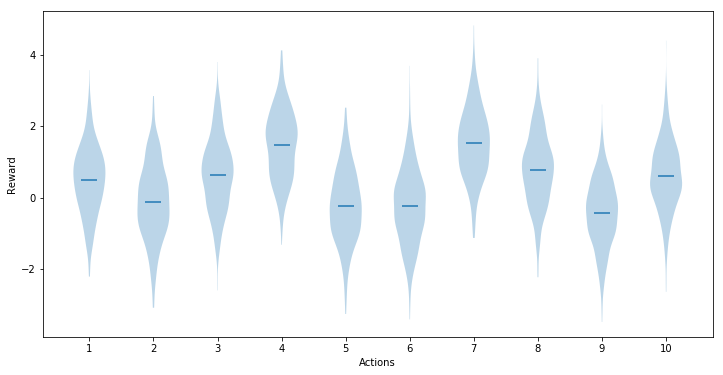

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

from kbandit import KBandit
k = 10
bandit = KBandit(k)

# For visualization purposes, we will sample the k actions
n_samples = 500
samples = np.zeros((n_samples, k))
for i in range(n_samples):
    for j in range(k):
        samples[i, j] = bandit.get_reward(j)

plt.figure(figsize=(12, 6))
plt.violinplot(samples, showmeans=True, showextrema=False);
plt.xlabel('Actions')
plt.ylabel('Reward')
plt.xticks(np.arange(1, k + 1));

We would expect each distribution to be exactly that of a normal distribution. Here, however, we are using `violinplot` to plot the distribution, which is estimated using the sample points. On the limit of an infinite number of samples, the visualized distribution should tend to the normal distribution.

With this test problem, we can now examine different action-value methods, which estimate value functions and use this estimates to take subsequent actions, seeking to maximize the long-term reward.

## Greedy and ε-greedy selection
We can estimate the value function at time $t$ for action $a$ as

$$Q_t(a) = \frac{\sum_{i=1}^t R_t I[A_i = a]}{\sum_{i=1}^t I[A_i = a]}$$

where $I$ is an indicator function equal to 1 when the predicate is true and 0 otherwise. The greedy action $A_t$ to take at time $t$ is the one that maximizes the estimated value function:

$$A_t = \arg\max_a Q_t(a)$$

This approach might not be the best if we want to balance exploitation and exploration. We can instead explore other options with probability $\epsilon$ by choosing any of them at random, and taking the greedy action with probability 1-$\epsilon$. Note that the greedy approach corresponds to the case where $\epsilon$ = 0. This method is known as **ε-greedy selection**.

We will now examine the average performance of these approaches on the test bandit described previously, by applying the methods 2000 runs, for 1000 steps each, and studying the average reward for each step, and the fraction of times (over all runs) the optimal action was taken. We will do this for different values of $\epsilon$.

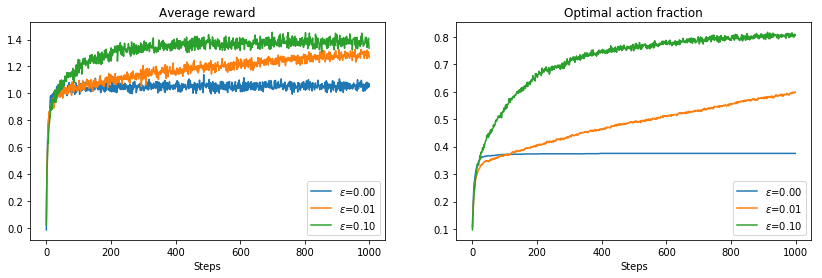

In [3]:
from action_value_methods import solve_bandit

# Number of runs over which the results are averaged
runs = 2000
# Time steps to run the selection method
steps = 1000
average_rewards = np.zeros(steps)
optimal_actions = np.zeros(steps)

plt.figure(figsize=(14, 4))
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(14, 4)
for eps in [0, 0.01, 0.1]:
    for run in range(runs):
        # Get new bandit problem and run the selection method
        bandit = KBandit(k)    
        results = solve_bandit(bandit, eps, steps)

        # Accumulate rewards and optimal action counts
        average_rewards += results[:, 1]
        optimal_idx = results[:, 0] == bandit.optimal_action
        optimal_actions[optimal_idx] += 1

    # Finalize averages
    average_rewards /= runs
    optimal_actions /= runs

    ax1.plot(average_rewards, label=r"$\epsilon$={:.2f}".format(eps))
    ax2.plot(optimal_actions, label=r"$\epsilon$={:.2f}".format(eps))

ax1.set_title("Average reward")
ax1.set_xlabel("Steps")
ax1.legend()
ax2.set_title("Optimal action fraction")
ax2.set_xlabel("Steps")
ax2.legend();

The results show how the balance between exploration and exploitation is crucial when aiming to maximize the long term reward. A completely greedy policy is only able to achieve an average reward of 1, as once it finds a best estimated value it keeps taking this action regardless of how better other alternatives might be. The exploration introduced by the ε-greedy approaches increases the average reward as well as the average fraction of times the optimal action is taken, which for the greedy method is below 30% of the time, in stark contrast with the 80% obtained by the ε-greedy approach with $\epsilon$ = 0.1.

## Upper Confidence Bound

Even though the ε-greedy approach allows us to introduce exploration in addition to exploitation of the best estimated action values, it does so regardless of how uncertain it is on the alternatives. Intuitively, actions for which there is higher uncertainty regarding their reward distribution should be given more opportunities than those for which the uncertainty is low. This is the idea of the Upper Confidence Bound criterion, which chooses the next action according to

$$A_t = \arg\max_a \left[Q_t(a) + c \sqrt{\frac{\ln t}{N_t(a)}}\right]$$

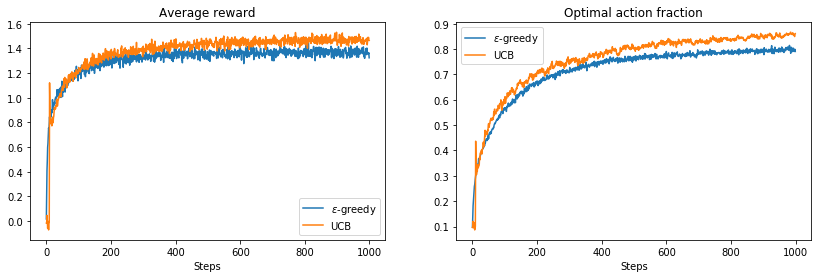

In [4]:
# Wrapper functions for predefined settings of the methods
def eps_greedy_solver(bandit):
    return solve_bandit(bandit, eps=0.1)

def ucb_solver(bandit):
    return solve_bandit(bandit, ucb=True, c=2)

average_rewards = np.zeros(steps)
optimal_actions = np.zeros(steps)

plt.figure(figsize=(14, 4))
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(14, 4)
for solver, label in ((eps_greedy_solver, r'$\epsilon$-greedy'), (ucb_solver, 'UCB')):
    for run in range(runs):
        # Get new bandit problem and run the selection method
        bandit = KBandit(k)    
        results = solver(bandit)

        # Accumulate rewards and optimal action counts
        average_rewards += results[:, 1]
        optimal_idx = results[:, 0] == bandit.optimal_action
        optimal_actions[optimal_idx] += 1

    # Finalize averages
    average_rewards /= runs
    optimal_actions /= runs

    ax1.plot(average_rewards, label=label)
    ax2.plot(optimal_actions, label=label)

ax1.set_title("Average reward")
ax1.set_xlabel("Steps")
ax1.legend()
ax2.set_title("Optimal action fraction")
ax2.set_xlabel("Steps")
ax2.legend();

We see that even though the difference is marginal, UCB definitely improves the obtained reward.

Reinforcement learning is a huge area of research and the methods presented here are very introductory, but their properties and limitations serve as basis for algorithms that work on more constrained problems. I really recommend the reference below to learn more about them.

### References
[1] Sutton, R. S., & Barto, A. G. (1998). Reinforcement learning: An introduction (Vol. 1, No. 1). Cambridge: MIT press.